### Semi Gradient  n-step SARSA

In this notebook, we will be using n-step SARSA with function approximation using Tiles to solve Mountain Car Environment.

![nStepSARSA](./images/nstepSarsa.png "n-Step SARSA")

In [3]:
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import gym

Mountain Car Environment


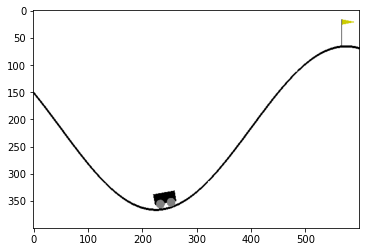

In [4]:
env = gym.make('MountainCar-v0') # rest of the code is designed to work only for this environment. It will require change for other environments

# increase episode length from 200 to 4000
env._max_episode_steps = 4000

np.random.seed(13)
env.reset()
print("Mountain Car Environment")
plt.imshow(env.render('rgb_array'))


In [5]:
# the implementation of tiles3 is from Richard Sutton's website
# http://incompleteideas.net/tiles/tiles3.html
from tiles3 import IHT, tiles

In [6]:
class QEstimator:

    def __init__(self, step_size, num_of_tilings=8, tiles_per_dim=8, max_size=2048, epsilon=0.0):
        self.max_size = max_size
        self.num_of_tilings = num_of_tilings
        self.tiles_per_dim = tiles_per_dim
        self.epsilon = epsilon
        self.step_size = step_size / num_of_tilings
        
        self.table = IHT(max_size)
        
        self.w = np.zeros(max_size)
        
        self.pos_scale = self.tiles_per_dim / (env.observation_space.high[0] \
                                                  - env.observation_space.low[0])
        self.vel_scale = self.tiles_per_dim / (env.observation_space.high[1] \
                                                  - env.observation_space.low[1])
        
    def get_active_features(self, state, action):
        pos, vel = state
        active_features = tiles(self.table, self.num_of_tilings,
                            [self.pos_scale * (pos - env.observation_space.low[0]), 
                             self.vel_scale * (vel- env.observation_space.low[1])],
                            [action])
        return active_features
        
    def q_predict(self, state, action):
        pos, vel = state
        if pos == env.observation_space.high[0]:  # reached goal
            return 0.0
        else:
            active_features = self.get_active_features(state, action)
            return np.sum(self.w[active_features])
        
    
    # learn with given state, action and target
    def q_update(self, state, action, target):
        active_features = self.get_active_features(state, action)
        q_s_a = np.sum(self.w[active_features])
        delta = (target - q_s_a)
        self.w[active_features] += self.step_size * delta
        
    def get_eps_greedy_action(self, state):
        pos, vel = state
        if np.random.rand() < self.epsilon:
            return np.random.choice(env.action_space.n)
        else:
            qvals = np.array([self.q_predict(state, action) for action in range(env.action_space.n)])
            return np.argmax(qvals)
            
    
    

In [7]:
def sarsa_n(qhat, step_size=0.5, epsilon=0.0, n=1, gamma=1.0, episode_cnt = 10000):
    episode_rewards = []
    for _ in range(episode_cnt):
        state = env.reset()
        action = qhat.get_eps_greedy_action(state)
        T = float('inf')
        t = 0
        states = [state]
        actions = [action]
        rewards = [0.0]
        while True:
            if t < T:
                next_state, reward, done, _ = env.step(action)
                states.append(next_state)
                rewards.append(reward)
                
                if done:
                    T = t+1
                else:
                    next_action = qhat.get_eps_greedy_action(next_state)
                    actions.append(next_action)

            tau = t - n + 1
            
            if tau >= 0:
                G = 0
                for i in range(tau+1, min(tau+n, T)+1):
                    G += gamma ** (i-tau-1) * rewards[i]
                if tau+n < T:
                    G += gamma**n * qhat.q_predict(states[tau+n], actions[tau+n])
                qhat.q_update(states[tau], actions[tau], G)
            
            if tau == T - 1:
                episode_rewards.append(np.sum(rewards))
                break
            else:
                t += 1
                state = next_state
                action = next_action
    
    return np.array(episode_rewards)
        
    
    
    

In [8]:
# plot rewards
def plot_rewards(env_name, rewards, label):
    plt.title("env={}, Mean reward = {:.1f}".format(env_name,np.mean(rewards[-20:])))
    plt.plot(rewards, label=label)
    plt.grid()
    plt.legend()
    plt.ylim(-500, 0)
    plt.show()

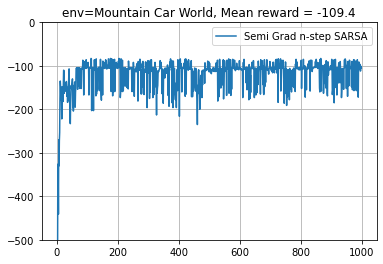

In [9]:
# create a n-SARSA Learning agent
step_size = 0.8
episode_cnt = 1000
n=4
epsilon= 0.0
gamma = 1.0

estimator = QEstimator(step_size, epsilon=epsilon)
rewards = sarsa_n(estimator, step_size=step_size, epsilon=epsilon, n=n, gamma=gamma, episode_cnt = episode_cnt)

#plot rewards
plot_rewards("Mountain Car World",rewards, 'Semi Grad n-step SARSA')

In [10]:
env.close()